In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class DecisionTree:
    def __init__(self, max_depth=10, min_gain=0.05, max_leaf=50):
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.max_leaf = max_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return self._create_leaf(y)

        best_split = self._find_best_split(X, y)
        if best_split['gain'] < self.min_gain:
            return self._create_leaf(y)

        left_indices = X[:, best_split['feature']] <= best_split['threshold']
        right_indices = X[:, best_split['feature']] > best_split['threshold']

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _find_best_split(self, X, y):
        best_split = {'gain': -1}
        n_samples, n_features = X.shape
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature], y, threshold)
                if gain > best_split['gain']:
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'gain': gain
                    }
        return best_split

    def _information_gain(self, feature_values, y, threshold):
        parent_variance = self._variance(y)
        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold
        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])

        var_left = self._variance(y[left_indices])
        var_right = self._variance(y[right_indices])

        child_variance = (n_left / n) * var_left + (n_right / n) * var_right
        ig = parent_variance - child_variance
        return ig

    def _variance(self, y):
        return np.var(y)

    def _create_leaf(self, y):
        return np.mean(y)

    def _predict_single(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree['feature']
        threshold = tree['threshold']
        if x[feature] <= threshold:
            return self._predict_single(x, tree['left'])
        else:
            return self._predict_single(x, tree['right'])

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_gain=0.1, max_leaf=200):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.max_leaf = max_leaf
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_subset, y_subset = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth, min_gain=self.min_gain, max_leaf=self.max_leaf)
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_predictions, axis=0)

class RandomForestWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_trees=10, max_depth=10, min_gain=0.1, max_leaf=200):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.max_leaf = max_leaf
        self.model = RandomForest(n_trees=n_trees, max_depth=max_depth, min_gain=min_gain, max_leaf=max_leaf)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def create_preprocessing_pipeline(continuous_features, categorical_features, n_bins=10):
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('kbd', kbd, continuous_features),
            ('ohe', ohe, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor


Mean Squared Error: 2397.2672960818754


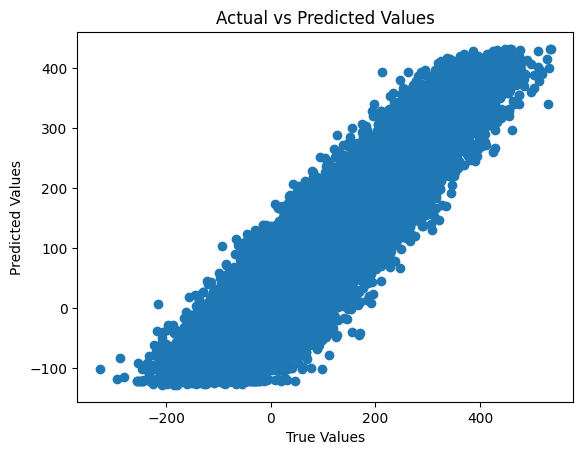

In [2]:
# Load the pipeline
with open('random_forest_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Read test data
test_file = 'train_data2.csv'  # Specify your test data file
df_test = pd.read_csv(test_file, index_col=0)

X_test = df_test.drop(columns=['outcome'])
y_true = df_test['outcome'].values

# Predict on the test set
y_pred = loaded_pipeline.predict(X_test)

# Calculate the mean squared error and plot actual vs predicted values
mse = np.mean((y_true - y_pred) ** 2)
print(f'Mean Squared Error: {mse}')

import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()